# Đánh giá điểm tín dụng sử dụng Decision Tree và Random Forest


Mục tiêu: 

- Xây dựng mô hình Decision Tree và Random Forest sử dụng thư viện sklearn. 
- Ứng dụng, hiểu cách áp dụng hai mô hình để giải bài toán thực tế (vd: đánh gia điểm tín dụng).
- Sử dụng độ đo thích hợp để đánh giá chất lượng mô hình. 

Vấn đề: 

- Yếu tố then chốt trong việc cho vay tín dụng là khả năng hoàn trả của người vay. Vì vậy đánh giá điểm tín dụng của người dùng là một bài toán được quan tâm trong lĩnh vực tài chính. Nhìn chung, đây là một bài toán phân lọai 2 lớp (good/bad score).
- Hơn nữa, số lượng bad credits thường ít hơn nhiều so với số lượng good credits ==> Dữ liệu nhãn lớp mất cân bằng.

Dữ liệu: 

- Thường ở dưới dạng bảng, mỗi hàng là một cá nhân vay, mỗi cột thể hiện một thuộc tính của cá nhân đó.
- Các trường thuộc tính tồn tại ở nhiều dạng: categorical, numeric (discrete / continuous). Thậm chí tên trường có thể được ẩn đi, hay giá trị thật sự được mã hõa để đảm bảo tính bảo mật của khách hàng.
- Hai tập dữ liệu sẽ sử dụng: German credit và Australian credit.

https://archive.ics.uci.edu/ml/datasets/Statlog+(Australian+Credit+Approval)

https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)

Bài toán: 

- Đầu vào: N vector D chiều, tương ứng N cá thể với D thuộc tính.
- Đầu ra: nhãn 0-1 (0: bad credit, 1: good credit).

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 

random_state = 42

## 1. Tìm hiểu dữ liệu

In [7]:
'''
- Tìm hiểu cấu trúc data tại trang web UCI
- Tải các files, đặt trong thư mục data/
- Làm với phiên bản 'numeric'
'''
data_path = 'Data/german.data-numeric'
credit=np.genfromtxt(data_path)
print(credit)
X,y = credit[:,:-1], credit[:,-1]
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


[[ 1.  6.  4. ...  0.  1.  1.]
 [ 2. 48.  2. ...  0.  1.  2.]
 [ 4. 12.  4. ...  1.  0.  1.]
 ...
 [ 4. 12.  2. ...  0.  1.  1.]
 [ 1. 45.  2. ...  0.  1.  2.]
 [ 2. 45.  4. ...  0.  1.  1.]]
(1000, 24) (1000,)
(800, 24) (200, 24)


## 2. Tìm hiểu mô hình Decision Tree, Random Forest của Sklearn

In [8]:
'''
- Decision Tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
'''
DT = DecisionTreeClassifier(random_state=random_state)

'''
- Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
'''
RF = RandomForestClassifier(random_state=random_state)

In [9]:
print('Demo DT and RF prediction')
DT.fit(X_train, y_train)
y_dt_pred = DT.predict(X_test)
print("-DT acc = {}".format(accuracy_score(y_test, y_dt_pred)))
print("-DT f1 = {}".format(f1_score(y_test, y_dt_pred)))
print("-DT roc auc = {}".format(roc_auc_score(y_test, y_dt_pred)))
print(confusion_matrix(y_test, y_dt_pred))

Demo DT and RF prediction
-DT acc = 0.665
-DT f1 = 0.7632508833922261
-DT roc auc = 0.5948431301839163
[[108  33]
 [ 34  25]]


### Bài 1: Chạy RF baseline

In [10]:
RF.fit(X_train, y_train)
y_rf_pred = RF.predict(X_test)

## 3. Tìm kiếm siêu tham số

In [17]:
# Utility functions
def grid_search(algorithm, n_jobs, dict_param):
    if algorithm == 'decision-tree':
        model = DecisionTreeClassifier()
    if algorithm == 'random-forest':
        model = RandomForestClassifier()
    classifier = GridSearchCV(estimator=model, cv=5, param_grid=dict_param,
                            n_jobs=n_jobs, scoring='f1')
    classifier.fit(X_train, y_train)
    print('Best model', end='')
    print(classifier.best_estimator_)
    return classifier.best_estimator_

def evaluate(model): 
    print("Train Accuracy :", accuracy_score(y_train, model.predict(X_train)))
    print("Train f1 score :", f1_score(y_train, model.predict(X_train)))  
    print("Train roc auc :", roc_auc_score(y_train, model.predict(X_train)))  
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, model.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, model.predict(X_test)))
    print("Test f1 score :", f1_score(y_test, model.predict(X_test)))
    print("Test roc auc :", roc_auc_score(y_test, model.predict(X_test)))  
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, model.predict(X_test)))

def plot_learning_curve(estimator, title, label_curve, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), new_plot=False,
                        idx_color=0):
    # Khởi tạo bức ảnh mới với thư viện plot lib 
    if new_plot:
        # plt.figure()
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.grid()
    # chú thích nếu có 
    if ylim is not None:
        plt.ylim(*ylim)
        
    # thực hiện training model, ghi nhận các giá trị trong quá trình training 
    # cv = số fold cross validate, số phần bộ dữ liệu được chia để thực hiện training testing.
    # train_sizes = mảng tỉ lệ, các tỉ lệ được hệ thống chọn làm điểm dừng để thực hiện 1 testing 
    #  train_sizes = [0.3, 0.5] => hệ thống lấy 30 % dữ liệu để train và thực hiện test, tương tự 50 % ..
    # scoring = hàm mục tiêu để đánh giá chất lượng mô hình và vẽ lên đồ thị 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="f1")
    # Lấy trung bình cộng các giá trị output của các fold 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # thực hiện vẽ các giá trị số lên đồ thị với màu vừa được random 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
             label=label_curve['test'])
    plt.plot(train_sizes, train_scores_mean, 'o-', color='g',
             label=label_curve['train'])

    plt.legend(loc="best")
    return plt

### 3.1 Decision Tree

Text(0.5, 1.0, 'DT validation curve for max_depth')

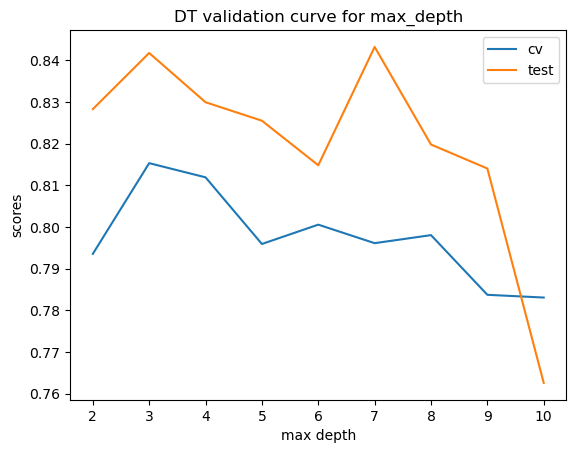

In [18]:
# Trước hết, hãy thử khảo sát DT với tham số max_depth
cv_accuracies_by_depth, test_accuracies_by_depth= [], []
max_depth_values= np.arange(2,11)

for curr_max_depth in max_depth_values:
  tree= DecisionTreeClassifier(random_state=random_state, max_depth=curr_max_depth)
  
  # cross-validation
  val_scores= cross_val_score(estimator=tree, X=X_train, y=y_train, cv=5, scoring='f1')
  cv_accuracies_by_depth.append(val_scores.mean())

  # test
  tree.fit(X_train, y_train)
  curr_pred= tree.predict(X_test)
  test_accuracies_by_depth.append(f1_score(curr_pred, y_test))

# Plot 
plt.plot(max_depth_values, cv_accuracies_by_depth, label='cv')
plt.plot(max_depth_values, test_accuracies_by_depth, label='test')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('scores')
plt.title('DT validation curve for max_depth')

In [19]:
# Thử sử dụng GridSearchCV để khảo sát
dict_param = {
    'max_depth': [2, 3, 5, 7, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
best_tree = grid_search('decision-tree', n_jobs=-1, dict_param=dict_param)


Best modelDecisionTreeClassifier(max_depth=5, min_samples_leaf=20)


### Bài 2: đánh giá best_tree
- Prediction performance
- Learning curve

In [21]:


print("Evaluating the best tree model:")


evaluate(best_tree)



Evaluating the best tree model:
Train Accuracy : 0.77125
Train f1 score : 0.8473728106755629
Train roc auc : 0.680523905314024
Train Confusion Matrix:
[[508  51]
 [132 109]]
--------------------------------------------------
Test Accuracy : 0.78
Test f1 score : 0.8533333333333334
Test roc auc : 0.6911888448130785
Test Confusion Matrix:
[[128  13]
 [ 31  28]]


Top 10 feature importances
Feature  0 - 0.40445005922715943
Feature  1 - 0.17066428015343657
Feature  2 - 0.14261352910286315
Feature  3 - 0.07120344185816782
Feature  4 - 0.05428847945598893
Feature  5 - 0.05400258515142507
Feature  6 - 0.04007488290946428
Feature  7 - 0.03813781829612112
Feature  8 - 0.015091674891623292
Feature  9 - 0.009473248953750433


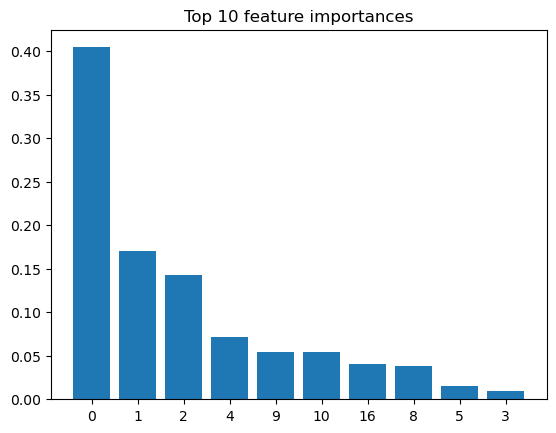

In [22]:
# Nhận xét về độ quan trọng của từng feature
importances = best_tree.feature_importances_
indices = np.argsort(importances)[::-1]
print('Top 10 feature importances')
for i in range(10):
    print('Feature ', i, '-', importances[indices[i]])

indices = indices[:10]
plt.figure()
plt.title('Top 10 feature importances')
plt.bar(range(10), importances[indices])
plt.xticks(range(10), indices)
plt.show()

###  3.2 Random Forest

### Bài 3: thực hành tương tự với RF

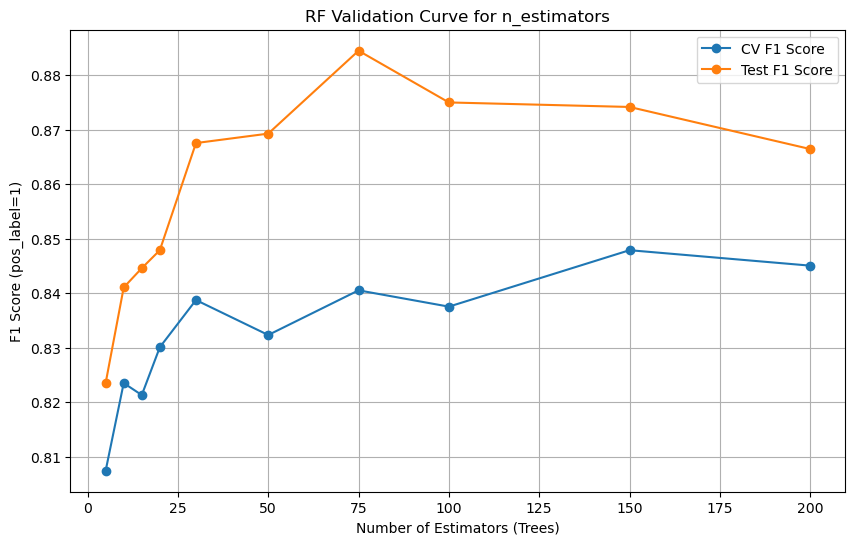

In [23]:
# Bài tập
# Tương tự, thử khảo sát RF với số lượng cây n_estimators
# code




num_trees = [5, 10, 15, 20, 30, 50, 75, 100, 150, 200]
cv_f1_by_n_estimators = []
test_f1_by_n_estimators = []

for n_est in num_trees:
    rf_temp = RandomForestClassifier(n_estimators=n_est, random_state=random_state, n_jobs=-1)

    # Cross-validation F1 score
    val_scores_rf = cross_val_score(estimator=rf_temp, X=X_train, y=y_train, cv=5, scoring='f1', n_jobs=-1)
    cv_f1_by_n_estimators.append(val_scores_rf.mean())

    # Test F1 score
    rf_temp.fit(X_train, y_train)
    y_pred_rf_temp = rf_temp.predict(X_test)
    test_f1_by_n_estimators.append(f1_score(y_test, y_pred_rf_temp, pos_label=1)) # Use F1 for class 1


plt.figure(figsize=(10, 6))
plt.plot(num_trees, cv_f1_by_n_estimators, 'o-', label='CV F1 Score')
plt.plot(num_trees, test_f1_by_n_estimators, 'o-', label='Test F1 Score')
plt.legend()
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('F1 Score (pos_label=1)')
plt.title('RF Validation Curve for n_estimators')
plt.grid(True)
plt.show()




Finding the best Random Forest model using GridSearchCV...
Best modelRandomForestClassifier(max_depth=11, max_features=6, n_estimators=75)

Evaluating the best Random Forest model:
Train Accuracy : 0.99375
Train f1 score : 0.9955476402493322
Train roc auc : 0.9896265560165975
Train Confusion Matrix:
[[559   0]
 [  5 236]]
--------------------------------------------------
Test Accuracy : 0.745
Test f1 score : 0.8327868852459016
Test roc auc : 0.6367952878951796
Test Confusion Matrix:
[[127  14]
 [ 37  22]]

Plotting Learning Curve for the best Random Forest model:


TypeError: plot_learning_curve() got an unexpected keyword argument 'axes'

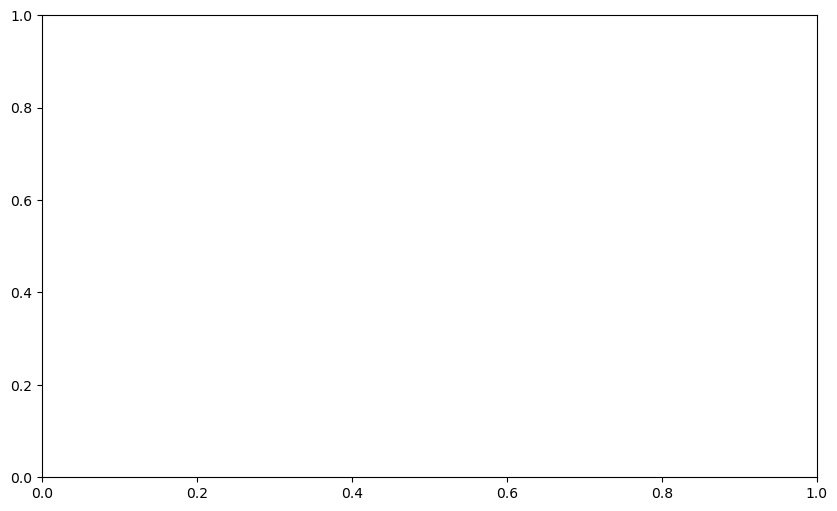

In [26]:
# Sử dụng GridSearch CV
dict_param = {
    'max_depth': [3, 11, 15, 24, 27], 
    'min_samples_leaf': [1, 5, 7, 9, 15, 24],
    'max_features':  [4, 6, 10, 16],
    'n_estimators': [75]
}
# - tìm best_forest
print("\nFinding the best Random Forest model using GridSearchCV...")
best_forest = grid_search('random-forest', n_jobs=-1, dict_param = dict_param)

# - Đánh giá best_forest và vẽ Learning Curve
print("\nEvaluating the best Random Forest model:")
evaluate(best_forest)

print("\nPlotting Learning Curve for the best Random Forest model:")
fig_rf, axes_rf = plt.subplots(1, 1, figsize=(10, 6))
plot_learning_curve(best_forest, "Learning Curve (Best Random Forest)",
                    {'train': 'Train', 'test': 'Cross-validation'},
                    X_train, y_train, axes=axes_rf, cv=5, n_jobs=-1, scoring='f1')
plt.show()

# - Tìm hiểu feature importance
print("\nFeature Importance for the best Random Forest model:")
importances_rf = best_forest.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

print('Top 10 feature importances (Random Forest):')
for i in range(10):
     # Print feature index and its importance score
     print(f'Feature {indices_rf[i]} - {importances_rf[indices_rf[i]]:.4f}')


plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances (Best Random Forest)')


plt.bar(range(10), importances_rf[indices_rf[:10]], align='center')
plt.xticks(range(10), indices_rf[:10])
plt.xlabel('Feature Index')
plt.ylabel('Importance Score (Gini Importance)')
plt.show()

print("-" * 60)

Mot so loi trong qua trinh ve bieu do nhung da tim duoc best forest

### 3.3 Thử nghiệm bổ sung

#### 3.3.1 Bỏ một số features có độ quan trọng thấp

In [61]:
# Thử bỏ một sô feature có độ quan trọng thấp đi
# Chú ý tham max_features cần thay đổi
sfm = SelectFromModel(best_forest, threshold='mean')
sfm.fit(X_train, y_train)
X_train_dropped = sfm.transform(X_train)
X_test_dropped = sfm.transform(X_test)

title = 'Learning with dropped features'
label_curve = {'train': 'train', 'test':'cv'}
forest_dropped = RandomForestClassifier(max_depth=11, min_samples_leaf=5,
                       n_estimators=75, n_jobs=-1, random_state=random_state)

# plot_learning_curve(forest_dropped, title, label_curve, X_train_dropped, y_train, cv=5)

forest_dropped.fit(X_train_dropped, y_train)
y_dropped_pred = forest_dropped.predict(X_test_dropped)
print('acc', accuracy_score(y_test, y_dropped_pred))
print('f1', f1_score(y_test, y_dropped_pred))
print('roc_auc', roc_auc_score(y_test, y_dropped_pred))

0.79


#### 3.3.2 Một số chiến lược áp dụng cho Random Forest khi gặp phải Class Imbalance
https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

In [29]:
'''
- Standard RF
'''
params = {
    'max_depth': best_forest.get_params()['max_depth'],
    'max_features': best_forest.get_params()['max_features'],
    'min_samples_leaf': best_forest.get_params()['min_samples_leaf'],
    'n_estimators': best_forest.get_params()['n_estimators'],
}
evaluate(best_forest)


Train Accuracy : 0.89875
Train f1 score : 0.931063829787234
Train roc auc : 0.8461130204351279
Train Confusion Matrix:
[[547  12]
 [ 69 172]]
--------------------------------------------------
Test Accuracy : 0.775
Test f1 score : 0.8524590163934427
Test roc auc : 0.8461130204351279
Test Confusion Matrix:
[[130  11]
 [ 34  25]]


In [30]:
'''
- Random Forest With Class Weighting
'''
rf1 = RandomForestClassifier(max_depth=params['max_depth'], max_features=params['max_features'],
                             min_samples_leaf = params['min_samples_leaf'], n_estimators=params['n_estimators'],
                             class_weight='balanced')
rf1.fit(X_train, y_train)
evaluate(rf1)

Train Accuracy : 0.9075
Train f1 score : 0.9326047358834244
Train roc auc : 0.9019440464967822
Train Confusion Matrix:
[[512  47]
 [ 27 214]]
--------------------------------------------------
Test Accuracy : 0.78
Test f1 score : 0.8439716312056738
Test roc auc : 0.9019440464967822
Test Confusion Matrix:
[[119  22]
 [ 22  37]]


In [31]:
'''
- Random Forest With Bootstrap Class Weighting
'''
'''
- Random Forest With Class Weighting
'''
rf2 = RandomForestClassifier(max_depth=params['max_depth'], max_features=params['max_features'],
                             min_samples_leaf = params['min_samples_leaf'], n_estimators=params['n_estimators'],
                             class_weight='balanced_subsample')
rf2.fit(X_train, y_train)
evaluate(rf2)

Train Accuracy : 0.91
Train f1 score : 0.9345454545454546
Train roc auc : 0.9037329552624351
Train Confusion Matrix:
[[514  45]
 [ 27 214]]
--------------------------------------------------
Test Accuracy : 0.78
Test f1 score : 0.8428571428571429
Test roc auc : 0.9037329552624351
Test Confusion Matrix:
[[118  23]
 [ 21  38]]


In [45]:
'''
- Random Forest With Random Undersampling
'''
from imblearn.ensemble import BalancedRandomForestClassifier
rf3 = BalancedRandomForestClassifier(max_depth=params['max_depth'], max_features=params['max_features'],
                             min_samples_leaf = params['min_samples_leaf'], n_estimators=params['n_estimators'],
                             )
rf3.fit(X_train, y_train)
evaluate(rf3)

0.24.0
